In [46]:
import pandas as pd
import numpy as np
import ast
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [47]:
movies = pd.read_csv('movie.csv')
tags = pd.read_csv('tag.csv')
genome_scores = pd.read_csv('genome_scores.csv')
genome_tags = pd.read_csv('genome_tags.csv')



In [48]:

print("Movies Count:")
print(movies.count())
print("\nTags Count:")
print(tags.count())
print("\nGenome scores Count:")
print(genome_scores.count())
print("\nGenome Tags Count:")
print(genome_tags.count())


Movies Count:
movieId    27278
title      27278
genres     27278
dtype: int64

Tags Count:
userId       465564
movieId      465564
tag          465548
timestamp    465564
dtype: int64

Genome scores Count:
movieId      11709768
tagId        11709768
relevance    11709768
dtype: int64

Genome Tags Count:
tagId    1128
tag      1128
dtype: int64


In [49]:
genome = pd.merge(genome_scores, genome_tags, on='tagId')
genome_sorted = genome.sort_values(['movieId', 'relevance'], ascending=[True, False])
top_genome_tags = genome_sorted.groupby('movieId').head(5)
top_genome_tags_grouped = top_genome_tags.groupby('movieId')['tag'].apply(list).reset_index()
top_genome_tags_grouped.rename(columns={'tag': 'genome_tags'}, inplace=True)

In [50]:
user_tags_grouped = tags.groupby('movieId')['tag'].apply(list).reset_index()
user_tags_grouped.rename(columns={'tag': 'user_tags'}, inplace=True)

In [51]:

movies = movies.merge(top_genome_tags_grouped, on='movieId', how='left')
movies = movies.merge(user_tags_grouped, on='movieId', how='left')


In [52]:

def process_genres(genres):
    try:
        return genres.lower().replace('|', ' ').split()
    except:
        return []

def clean_tags(tag_list):
    try:
        return [str(tag).lower().replace(' ', '') for tag in tag_list if isinstance(tag, str)]
    except:
        return []

movies['genres'] = movies['genres'].apply(process_genres)
movies['genome_tags'] = movies['genome_tags'].apply(clean_tags)
movies['user_tags'] = movies['user_tags'].apply(clean_tags)

In [53]:

movies['tags'] = movies['genres'] + movies['genome_tags'] + movies['user_tags']
movies['tags'] = movies['tags'].apply(lambda x: ' '.join(x))


In [54]:

tfidf = TfidfVectorizer(max_features=5000, stop_words='english')
tfidf_matrix = tfidf.fit_transform(movies['tags'])

In [55]:

similarity = cosine_similarity(tfidf_matrix)

In [56]:
def recommend(title, top_n=5):
    if title not in movies['title'].values:
        return "Movie not found."

    idx = movies[movies['title'] == title].index[0]
    distances = list(enumerate(similarity[idx]))
    sorted_movies = sorted(distances, key=lambda x: x[1], reverse=True)[1:top_n+1]

    recommended_titles = [movies.iloc[i[0]]['title'] for i in sorted_movies]
    return recommended_titles

In [57]:
print(recommend("Iron Man (2008)"))


['Iron Man 3 (2013)', 'Iron Man 2 (2010)', 'Avengers, The (2012)', 'Avengers Confidential: Black Widow & Punisher (2014)', 'Elektra (2005)']


In [58]:
def is_relevant(source_idx, rec_idx):
    source_genres = set(movies.iloc[source_idx]['genres'])
    rec_genres = set(movies.iloc[rec_idx]['genres'])
    return int(len(source_genres & rec_genres) > 0)


def evaluate_model(top_n=5, sample_size=100):
    y_true_all = []
    y_pred_scores_all = []
    y_pred_binary_all = []
    for idx in movies.sample(sample_size, random_state=42).index:
        
        for jdx, score in enumerate(similarity[idx]):
            if idx==jdx: continue
            y_true_all.append(is_relevant(idx, jdx))
            y_pred_scores_all.append(score)
       
        top_scores = sorted(similarity[idx], reverse=True)[1:top_n+1]
        thresh = min(top_scores)
        for jdx, score in enumerate(similarity[idx]):
            if idx==jdx: continue
            y_pred_binary_all.append(int(score>=thresh))
            
    mse = mean_squared_error(y_true_all, y_pred_scores_all)
    mae = mean_absolute_error(y_true_all, y_pred_scores_all)
    precision = precision_score(y_true_all, y_pred_binary_all)
    recall = recall_score(y_true_all, y_pred_binary_all)
    f1 = f1_score(y_true_all, y_pred_binary_all)
    auc = roc_auc_score(y_true_all, y_pred_scores_all)
    return {'MSE': mse, 'MAE': mae, 'Precision': precision,
            'Recall': recall, 'F1': f1, 'AUC': auc, 'y_true': y_true_all,
            'y_scores': y_pred_scores_all}

metrics = evaluate_model(top_n=5, sample_size=200)

In [59]:
print("Evaluation Metrics:")
for k,v in metrics.items():
    if k in ['y_true','y_scores']: continue
    print(f"{k}: {v:.4f}")


Evaluation Metrics:
MSE: 0.3208
MAE: 0.3480
Precision: 0.9958
Recall: 0.0161
F1: 0.0318
AUC: 0.9794


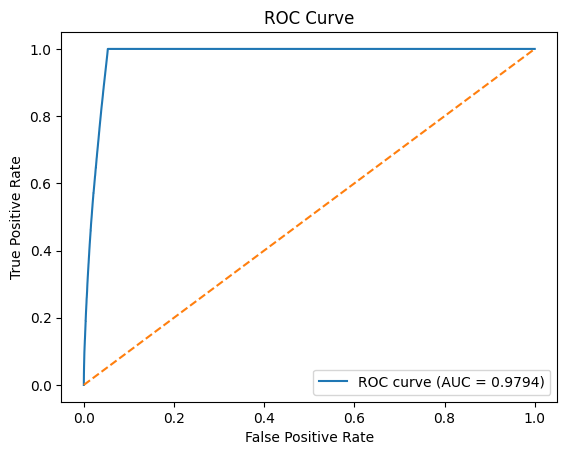

In [60]:
fpr, tpr, _ = roc_curve(metrics['y_true'], metrics['y_scores'])
plt.figure()
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {metrics['AUC']:.4f})")
plt.plot([0,1],[0,1],'--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

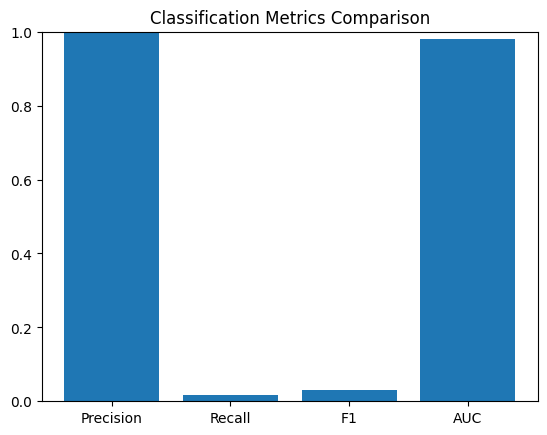

In [62]:
plt.figure()
names = ['Precision','Recall','F1','AUC']
values = [metrics[n] for n in names]
plt.bar(names, values)
plt.ylim(0,1)
plt.title('Classification Metrics Comparison')
plt.show()